## Notebook for playing around with Data Assimilation of seasonal data

Author: **N.J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assitant Professor Vrije Universiteit Amsterdam

In [2]:
# Load packages
import numpy as np # The 'numpy' package is needed for matrix operations and calculations
import pandas as pd # The 'pandas' package helps us to import and manage data
import math as math # Math package for data cleaning
# ---TO DO: Install D47calib and use here--- https://github.com/mdaeron/D47calib
# import D47calib as D47c # Import the package for treating clumped isotope data by Daëron and Vermeesch (2023)
import matplotlib.pyplot as plt # The 'matplotlib' package contains tools needed to plot our data and results
%matplotlib inline

# PRIOR

In [3]:
# Load model data as prior and show data structure
PlioMIP = pd.read_csv('PWP case/PlioMIP_SST.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PlioMIP.head()

,modelname,ja,fb,mr,ar,my,jn,jl,ag,sp,ot,nv,dc
0,CCSM4-UoT,8.33,7.14,7.45,9.67,13.33,18.40,22.50,24.35,22.60,18.74,14.83,10.86
1,CCSM4-Utr,9.96,8.75,8.95,11.03,14.62,19.37,23.50,25.29,23.95,20.76,16.37,12.48
2,COSMOS,7.91,6.68,6.38,7.34,9.53,12.23,14.95,15.94,14.94,13.34,11.49,9.58
3,EC-Earth3.3,9.18,7.62,7.41,9.32,13.58,19.22,24.06,25.27,23.56,20.26,16.05,12.13
4,GISS2.1G,4.87,3.58,3.88,6.75,11.21,15.56,18.68,19.39,17.68,14.47,10.53,7.18


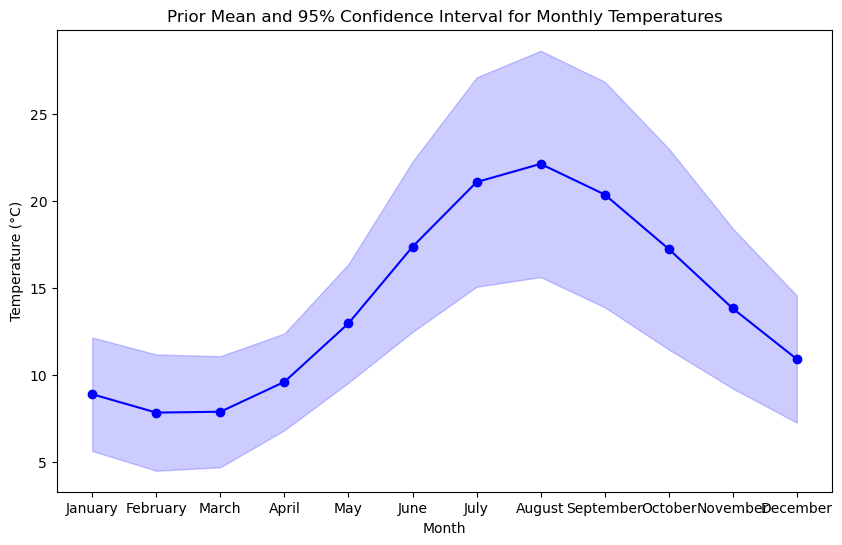

In [32]:
# Establish and plot prior distribution based on PlioMIP model outcomes

# Initial conditions
n_months = 12
n_models = 11

# Prior estimates from climate models (mean and covariance)
mu_prior = PlioMIP.iloc[:,1:13].mean() # Replace with your climate model means
cov_prior = np.cov(PlioMIP.iloc[:,1:13], rowvar=False) # Prior covariance matrix

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior = np.sqrt(np.diag(cov_prior))

# Plot prior distribution
# Plotting the prior mean and uncertainty
months = np.arange(1, n_months + 1) # Create monthly scale
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(10, 6))
plt.plot(months, mu_prior, label = 'Prior Mean', color = 'b', marker = 'o')
plt.title('Prior Mean and 95% Confidence Interval for Monthly Temperatures')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')

# Adding 95% confidence intervals (mean ± 1.96 * standard deviation)
plt.fill_between(months, mu_prior - 1.96 * std_prior, mu_prior + 1.96 * std_prior, 
                 color='b', alpha = 0.2, label='95% Confidence Interval')

# Update the x-axis with month names
plt.xticks(months, month_names)
plt.show() # Show plot

# UPDATE

In [17]:
# Load measurements and format them into a dictionary
PWP_D47 = pd.read_csv('PWP case/PWP_proxy_data.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PWP_D47_dict = PWP_D47.to_dict('records') # Convert to dictionary with column headers as keys
print(PWP_D47_dict[2]['Month'])
print(mu_prior[4])
# measurements = filter(lambda k: not isnan(PWP_D47_dict[k]), PWP_D47_dict)
# measurements = {k: PWP_D47_dict[k] for k in PWP_D47_dict if not math.isnan(PWP_D47_dict[k])}
# print(measurements)

4
12.97272727272727


C:\Users\nwi213\AppData\Local\Temp\ipykernel_28140\3843976681.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(mu_prior[4])


In [19]:
# Create updating function
def kalman_update(mu_prior, cov_prior, measurement):
    month = measurement['Month'] - 1  # Zero-indexed for Python arrays
    obs_temp = measurement['T_mean']
    obs_var = measurement['T_sd'] ** 2
    
    # Prior mean and variance for the specific month
    mu_prior_month = mu_prior[month]
    cov_prior_month = cov_prior[month, month]

    # Kalman gain
    K = cov_prior_month / (cov_prior_month + obs_var)

    # Update mean and variance
    mu_post = mu_prior_month + K * (obs_temp - mu_prior_month)
    cov_post = (1 - K) * cov_prior_month

    # Update the prior arrays with the new posterior values
    mu_prior[month] = mu_post
    cov_prior[month, month] = cov_post
    
    return mu_prior, cov_prior

In [29]:
measurement = PWP_D47_dict[664]

month = measurement['Month'] - 1  # Zero-indexed for Python arrays
obs_temp = measurement['T_mean']
obs_var = measurement['T_sd'] ** 2

# Prior mean and variance for the specific month
mu_prior_month = mu_prior[month]
cov_prior_month = cov_prior[month, month]

# Kalman gain
K = cov_prior_month / (cov_prior_month + obs_var)

print(K)

# Update mean and variance
mu_post = mu_prior_month + K * (obs_temp - mu_prior_month)
cov_post = (1 - K) * cov_prior_month

# Update the prior arrays with the new posterior values
mu_prior[month] = mu_post
cov_prior[month, month] = cov_post

nan


C:\Users\nwi213\AppData\Local\Temp\ipykernel_28140\1409534224.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu_prior_month = mu_prior[month]
C:\Users\nwi213\AppData\Local\Temp\ipykernel_28140\1409534224.py:21: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  mu_prior[month] = mu_post


In [ ]:
# Test function
mu_post, cov_post = kalman_update(mu_prior, cov_prior, PWP_D47_dict[2]) # Update the mean and covariance matrix of the monthly temperature values

print(mu_prior)
print(mu_post)

ja      8.899091
 fb     7.841818
 mr     7.891818
 ar     9.612960
 my    12.972727
 jn    17.379091
 jl    21.100000
 ag    22.147273
 sp    20.386364
 ot    17.252727
 nv    13.831818
 dc    10.918182
dtype: float64
ja      8.899091
 fb     7.841818
 mr     7.891818
 ar     9.612960
 my    12.972727
 jn    17.379091
 jl    21.100000
 ag    22.147273
 sp    20.386364
 ot    17.252727
 nv    13.831818
 dc    10.918182
dtype: float64


C:\Users\nwi213\AppData\Local\Temp\ipykernel_28140\2117494628.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu_prior_month = mu_prior[month]
C:\Users\nwi213\AppData\Local\Temp\ipykernel_28140\2117494628.py:19: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  mu_prior[month] = mu_post


In [33]:
# Update the prior with all measurements
for measurement in PWP_D47_dict[1:662]: # Loop over measurements
    mu_prior, cov_prior = kalman_update(mu_prior, cov_prior, measurement) # Update the mean and covariance matrix of the monthly temperature values

print(mu_prior)

ja      9.662967
 fb     8.031143
 mr     9.323840
 ar     8.649103
 my    11.722147
 jn    13.354820
 jl    13.711396
 ag    13.478750
 sp     8.534947
 ot    11.903584
 nv    11.924720
 dc    10.408191
dtype: float64


C:\Users\nwi213\AppData\Local\Temp\ipykernel_28140\2117494628.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu_prior_month = mu_prior[month]
C:\Users\nwi213\AppData\Local\Temp\ipykernel_28140\2117494628.py:19: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  mu_prior[month] = mu_post


# POSTERIOR

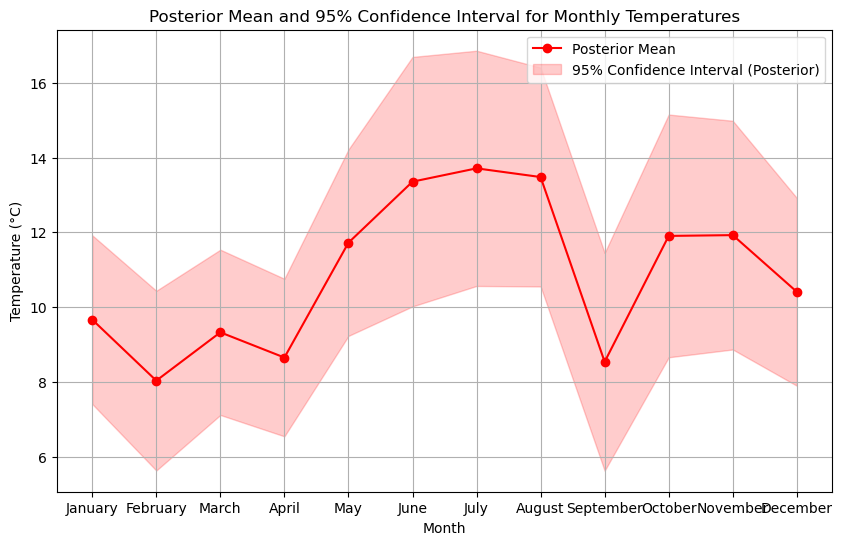

In [34]:
# Plot the updated posterior
std_post = np.sqrt(np.diag(cov_prior))

plt.figure(figsize=(10, 6))
plt.plot(months, mu_prior, label='Posterior Mean', color='r', marker='o')

# Adding 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months, mu_prior - 1.96 * std_post, mu_prior + 1.96 * std_post, 
                 color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

plt.xticks(months, month_names)
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()